In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import math
from scipy import stats
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import metrics

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy.io import loadmat
import os
import utils
from scipy.optimize import fmin_cg
import scipy.io
import scipy.io as si

In [2]:
mydata = loadmat('data/ex4data1.mat')
mydata

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
X, y = mydata['X'], mydata['y'].ravel()
#give numbers from 0 to 9
y[np.flatnonzero(y==10)] = 0
y

array([0, 0, 0, ..., 9, 9, 9], dtype=uint8)

In [4]:
y.shape

(5000,)

In [5]:
X.shape

(5000, 400)

# The images are of size 20 * 20, this gives us 400 input layer units

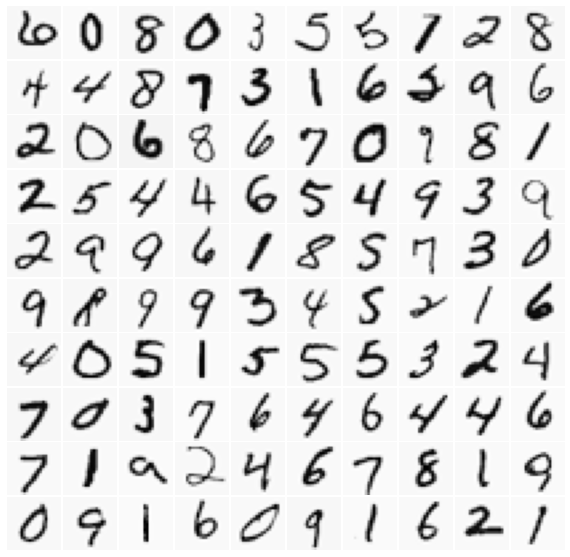

In [6]:
# Vitualize data 
# The code randomly selects selects 100 rows from X and passes those rows to the displayData function. This function maps each row to a 20 pixel by
#20 pixel grayscale image and displays the images together. The displayData function is given in the exersize.

m = y.size
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

utils.displayData(sel)

===================================================================================================
# Neural Networks

# Here we have 3 layers - an input layer, a hidden layer and an output layer.

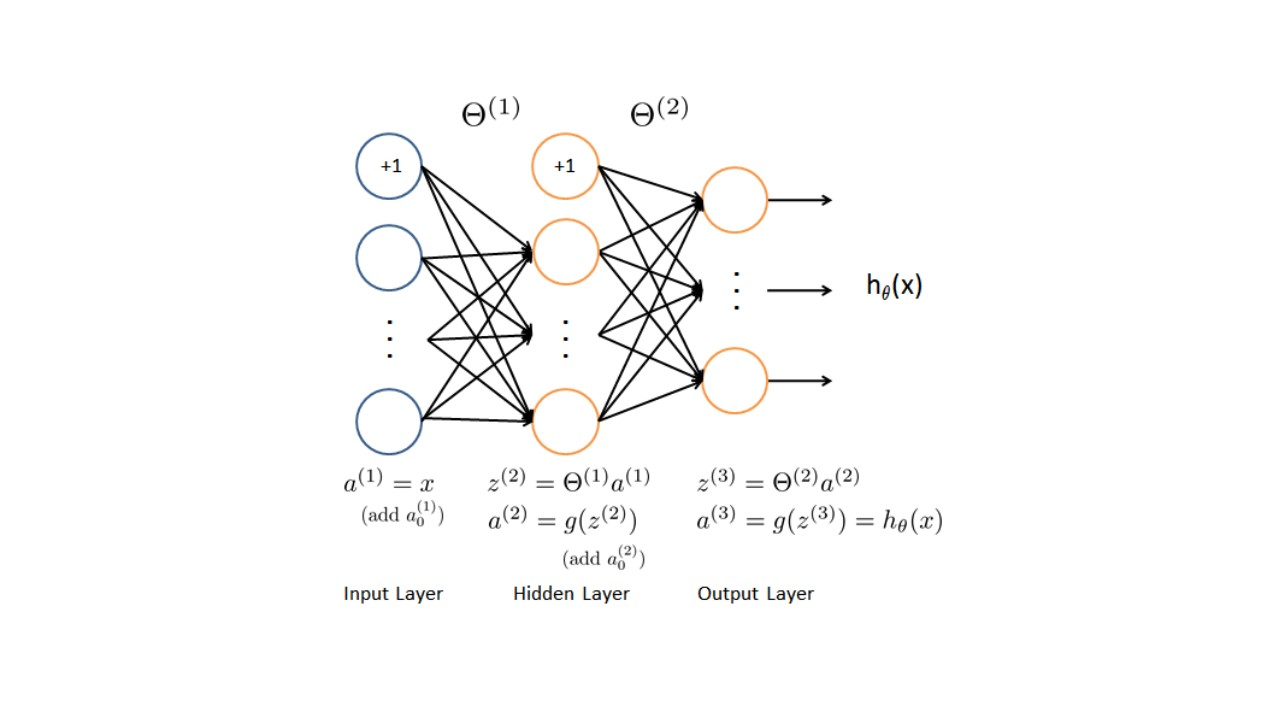

In [7]:
from IPython import display
display.Image("./ex3,NN.jpg", width=800)

#  Neural Network Cost Function (Forward)
# $h_{\theta}(x)=g(\theta^T x)$, where g is sigmoind function
#  $g(z)=\frac{1}{1+e^{-z}}$
## and the cost
# $J(\theta)=\frac{1}{m}{\sum\limits_{K=1}^{K}}{\sum\limits_{i=1}^{m}}(-y_K^{(i)}log(h_{\theta}(x^{(i)})_K)-(1-y_K^{(i)})log(1-h_{\theta}(x^{(i)}))_K)+\\
\frac{\lambda}{2m} \bigg[\sum\limits_{K=1}^{400} \sum\limits_{i=1}^{25}(\theta^{(1)}_{j,K})^2 
+ \sum\limits_{K=1}^{25} \sum\limits_{i=1}^{10}(\theta^{(1)}_{j,K})^2 \bigg]$

In [8]:
def sigmoid(z):
    return  1 / (1 + np.exp(-z))

## $\theta_1$ and $\theta_2$ are given in this exercise

In [9]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

In [10]:

# Load the weights into variables Theta1 and Theta2
weights = loadmat(os.path.join('Data', 'ex4weights.mat'))

# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

# Unroll parameters 
nn_params = np.concatenate([Theta1.ravel(), Theta2.ravel()])


In [47]:
def nn_cost_function(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lambda_):
    
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1))) # 25 x 401

    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1))) # 10 x 26

    m = y.size
         
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    
    a1 = np.concatenate([np.ones((m, 1)), X], axis=1) 
   
    z2 = np.dot(a1, Theta1.T) 
    a2 = utils.sigmoid(z2)
    # Add a column of bias units to a2(as the first column)
    a2 = np.concatenate([np.ones((m, 1)), a2], axis=1)  # 5000 x 26
        
    z3 = np.dot(a2, Theta2.T)
    a3 = utils.sigmoid(z3)    
        
    # Encode the labels as vectors containing only values 0 or 1
    y_matrix = y.reshape(-1)
    #np.eye returns a 2-D array with ones on the diagonal and zeros elsewhere.
    y_matrix = np.eye(num_labels)[y_matrix]
        
    Reg = (lambda_/(2*m)) * (np.sum(np.square(Theta1[:, 1:])) + np.sum(np.square(Theta2[:, 1:])))    
    J = (-1/m) * (np.sum(y_matrix * np.log(a3) + (1-y_matrix) * np.log(1-a3)))+Reg
    
    gradient = np.concatenate([Theta1_grad.ravel(), Theta2_grad.ravel()])

    return J, gradient 

In [48]:
y_matrix = y.reshape(-1)
y_matrix = np.eye(num_labels)[y_matrix]
y_matrix


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [49]:
y.reshape(-1)

array([0, 0, 0, ..., 9, 9, 9], dtype=uint8)

In [50]:
a1 = np.concatenate([np.ones((m, 1)), X], axis=1)
z2 = np.dot(a1, Theta1.T)
a2 = utils.sigmoid(z2)
a2 = np.concatenate([np.ones((m, 1)), a2], axis=1)
z3 = np.dot(a2, Theta2.T)
a3 = utils.sigmoid(z3)
a3

array([[9.95734012e-01, 1.12661530e-04, 1.74127856e-03, ...,
        5.51517524e-03, 4.01468105e-04, 6.48072305e-03],
       [9.95696931e-01, 4.79026796e-04, 2.41495958e-03, ...,
        1.15788527e-02, 2.39107046e-03, 1.97025086e-03],
       [9.28008397e-01, 8.85702310e-05, 3.24266731e-03, ...,
        3.86839058e-04, 6.22892325e-02, 5.49803551e-03],
       ...,
       [2.42384687e-05, 5.17641791e-02, 3.81715020e-03, ...,
        1.44301919e-04, 2.15667361e-03, 6.49826950e-01],
       [2.06173648e-04, 8.30631310e-04, 6.22003774e-04, ...,
        1.20516046e-02, 1.19366192e-02, 9.71410499e-01],
       [8.18576980e-02, 4.81465717e-05, 4.58821829e-04, ...,
        3.69700393e-02, 5.73434571e-03, 6.96288990e-01]])

In [51]:
a2

array([[1.00000000e+00, 5.03618685e-02, 7.93957162e-02, ...,
        9.72517962e-01, 9.43421623e-01, 1.07213787e-01],
       [1.00000000e+00, 8.05782163e-03, 5.10486829e-02, ...,
        8.91385592e-01, 9.90982126e-01, 5.94701645e-02],
       [1.00000000e+00, 1.41949887e-02, 2.44354705e-02, ...,
        8.24334311e-01, 9.56466386e-01, 8.86760824e-02],
       ...,
       [1.00000000e+00, 2.96781175e-01, 7.32901746e-01, ...,
        8.60396828e-01, 3.98474223e-02, 1.51177198e-01],
       [1.00000000e+00, 8.51205095e-01, 3.58434539e-01, ...,
        9.84854863e-01, 2.75399966e-01, 4.35605471e-02],
       [1.00000000e+00, 9.72262381e-01, 5.48598771e-06, ...,
        9.99235749e-01, 8.96120297e-01, 5.00966928e-02]])

In [35]:
y_matrix * np.log(a3)

array([[-0.00427511, -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.00431235, -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.0747145 , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.43104918],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.02900614],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.36199049]])

In [45]:
lambda_ = 0
J,_ = nn_cost_function(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lambda_)
J

0.2876291651613189

In [46]:
lambda_ = 1
J,_ = nn_cost_function(nn_params, input_layer_size, hidden_layer_size,
                   num_labels, X, y, lambda_)
J

0.38376985909092365

# Backpropagation